In [1]:
# Importy i konfiguracja wykresów
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 4)

# Analiza szeregów czasowych – Laboratorium 5 (29 X 2025)

Tematy:

- Holt–Winters (addytywny, opcjonalnie multiplikatywny)

- Prognozy punktowe i przedziałowe; ocena jakości (RMSE, MAE, MAPE)

- Dekompozycja STL i prognozowanie



Dane: `PLGDPQ.csv` (realny PKB Polski, kwartalnie).

In [2]:
# 1) Wczytanie danych i budowa szeregu Xts (kwartalnego)
# Dane w tym samym folderze co notebook
csv_path = "PLGDPQ.csv"
dane = pd.read_csv(csv_path, header=0, decimal='.')
dane.columns = ["Data","PKB"]
# Szereg kwartalny od 2003Q1 (częstotliwość 4)
# Użyjemy PeriodIndex (Q) -> DatetimeIndex
start_year, start_quarter = 2003, 1
idx = pd.period_range(start=f"{start_year}Q{start_quarter}", periods=len(dane), freq="Q")
Xts = pd.Series(dane["PKB"].astype(float).to_numpy(), index=idx.to_timestamp())
dane.head()

,Data,PKB
0,2003-01-01,244364.393792
1,2003-04-01,259314.197167
2,2003-07-01,263203.649299
3,2003-10-01,293402.554525
4,2004-01-01,261965.546518


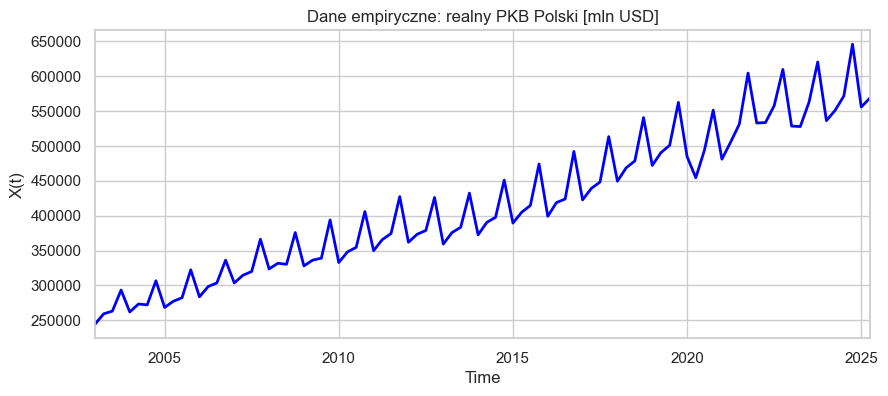

In [3]:
# Wykres szeregu PKB
ax = Xts.plot(color='blue', lw=2, title='Dane empiryczne: realny PKB Polski [mln USD]')
ax.set_xlabel('Time')
ax.set_ylabel('X(t)')
plt.grid(True)
plt.show()

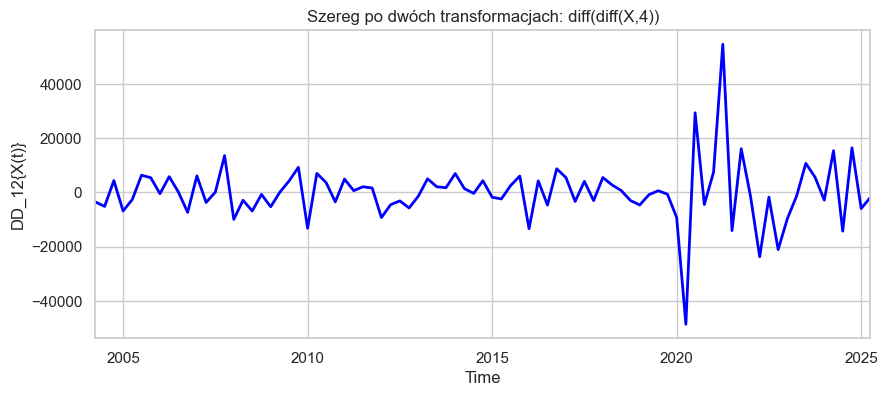

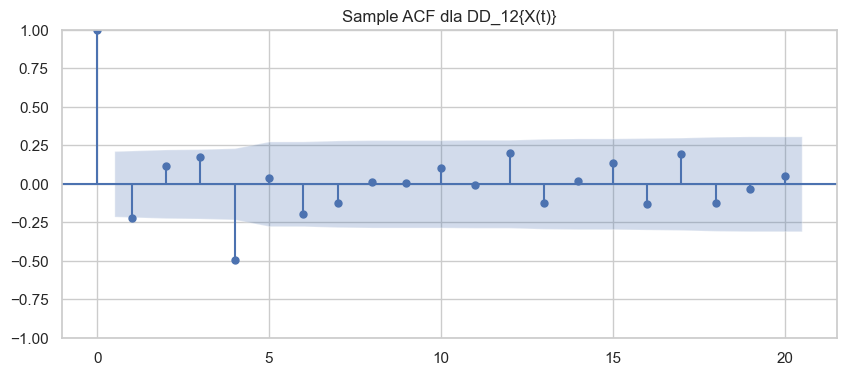

In [4]:
# 1') Dwukrotne różnicowanie: najpierw sezonowe (lag=4), potem zwykłe
Xts_seas_diff = Xts.diff(4)
Xts_2 = Xts_seas_diff.diff().dropna()

ax = Xts_2.plot(color='blue', lw=2, title='Szereg po dwóch transformacjach: diff(diff(X,4))')
ax.set_xlabel('Time')
ax.set_ylabel('DD_12{X(t)}')
plt.grid(True)
plt.show()

plot_acf(Xts_2, lags=20)
plt.title('Sample ACF dla DD_12{X(t)}')
plt.show()

Parametry wygładzania (alpha, beta, gamma): 0.6472873635443659 0.0 0.3527126364556341


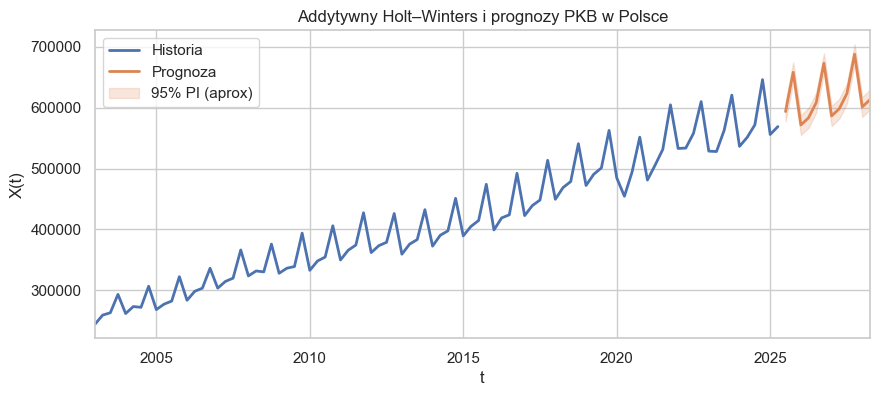

,point_forecast,lo95,hi95
2025-07-01,593512.879236,577172.816042,609852.942430
2025-10-01,657914.694185,641574.630991,674254.757379
2026-01-01,571438.925855,555098.862662,587778.989049
2026-04-01,583233.921243,566893.858049,599573.984437
2026-07-01,608355.006537,592014.943343,624695.069731
2026-10-01,672756.821486,656416.758292,689096.884680
2027-01-01,586281.053157,569940.989963,602621.116351
2027-04-01,598076.048544,581735.985350,614416.111738
2027-07-01,623197.133838,606857.070644,639537.197032
2027-10-01,687598.948788,671258.885594,703939.011981


In [5]:
# 2) Holt–Winters (addytywny) i prognozy ex-ante
H = 12  # 3 lata kwartalnie

hw_add = ExponentialSmoothing(
    Xts,
    trend='add',
    seasonal='add',
    seasonal_periods=4,
    initialization_method='estimated'
).fit(optimized=True)

# Parametry wygładzania
alpha = hw_add.model.params.get('smoothing_level', None)
beta  = hw_add.model.params.get('smoothing_trend', None)
gamma = hw_add.model.params.get('smoothing_seasonal', None)
print('Parametry wygładzania (alpha, beta, gamma):', alpha, beta, gamma)

# Prognoza punktowa i przedziałowa ~ przybliżona (na bazie odchylenia reszt)
fc_add = hw_add.forecast(H)
resid_std = np.nanstd(hw_add.resid, ddof=1)
z = 1.96
ci_low = fc_add - z * resid_std
ci_high = fc_add + z * resid_std

# Wykres
fig, ax = plt.subplots()
Xts.plot(ax=ax, color='C0', lw=2, label='Historia')
fc_add.plot(ax=ax, color='C1', lw=2, label='Prognoza')
ax.fill_between(fc_add.index, ci_low, ci_high, color='C1', alpha=0.2, label='95% PI (aprox)')
ax.set_title('Addytywny Holt–Winters i prognozy PKB w Polsce')
ax.set_xlabel('t')
ax.set_ylabel('X(t)')
ax.legend(loc='best')
ax.grid(True)
plt.show()

pd.DataFrame({'point_forecast': fc_add, 'lo95': ci_low, 'hi95': ci_high})

Parametry wygładzania (alpha, beta, gamma) [mul]: 0.6973436013910327 0.014504929856736928 0.23363254664850877


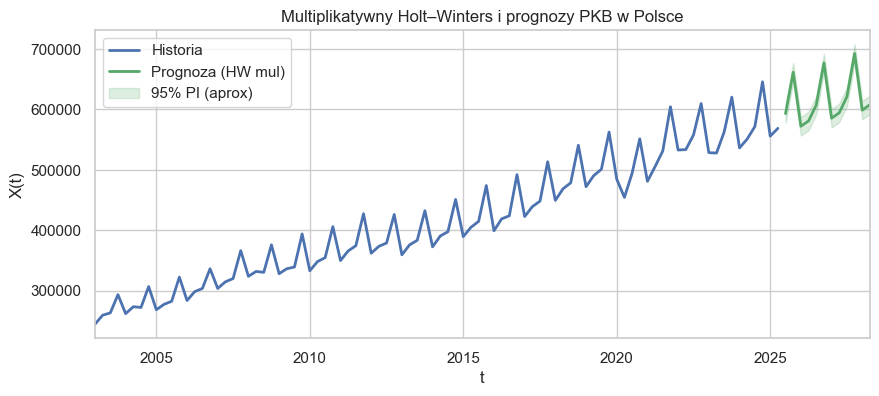

,point_forecast,lo95,hi95
2025-07-01,593208.864936,577877.660720,608540.069151
2025-10-01,661629.855969,646298.651753,676961.060184
2026-01-01,572195.989661,556864.785446,587527.193877
2026-04-01,581043.467503,565712.263287,596374.671718
2026-07-01,607218.855652,591887.651437,622550.059868
2026-10-01,677164.046736,661832.842521,692495.250952
2027-01-01,585551.996634,570220.792418,600883.200849
2027-04-01,594527.305530,579196.101315,609858.509746
2027-07-01,621228.846369,605897.642153,636560.050584
2027-10-01,692698.237503,677367.033288,708029.441719


In [6]:
# 2a) Holt–Winters (multiplikatywny) i prognozy ex-ante
hw_mul = ExponentialSmoothing(
    Xts,
    trend='add',
    seasonal='mul',
    seasonal_periods=4,
    initialization_method='estimated'
).fit(optimized=True)

# Parametry wygładzania
alpha_m = hw_mul.model.params.get('smoothing_level', None)
beta_m  = hw_mul.model.params.get('smoothing_trend', None)
gamma_m = hw_mul.model.params.get('smoothing_seasonal', None)
print('Parametry wygładzania (alpha, beta, gamma) [mul]:', alpha_m, beta_m, gamma_m)

# Prognoza punktowa i przybliżone przedziały (aproks. addytywna na resztach)
fc_mul = hw_mul.forecast(H)
resid_std_m = np.nanstd(hw_mul.resid, ddof=1)
z = 1.96
ci_low_m = fc_mul - z * resid_std_m
ci_high_m = fc_mul + z * resid_std_m

# Wykres
fig, ax = plt.subplots()
Xts.plot(ax=ax, color='C0', lw=2, label='Historia')
fc_mul.plot(ax=ax, color='C2', lw=2, label='Prognoza (HW mul)')
ax.fill_between(fc_mul.index, ci_low_m, ci_high_m, color='C2', alpha=0.2, label='95% PI (aprox)')
ax.set_title('Multiplikatywny Holt–Winters i prognozy PKB w Polsce')
ax.set_xlabel('t')
ax.set_ylabel('X(t)')
ax.legend(loc='best')
ax.grid(True)
plt.show()

pd.DataFrame({'point_forecast': fc_mul, 'lo95': ci_low_m, 'hi95': ci_high_m})

RMSE, MAE, MAPE[%]: 56896.84235313234 44510.28544281761 8.222717344771414


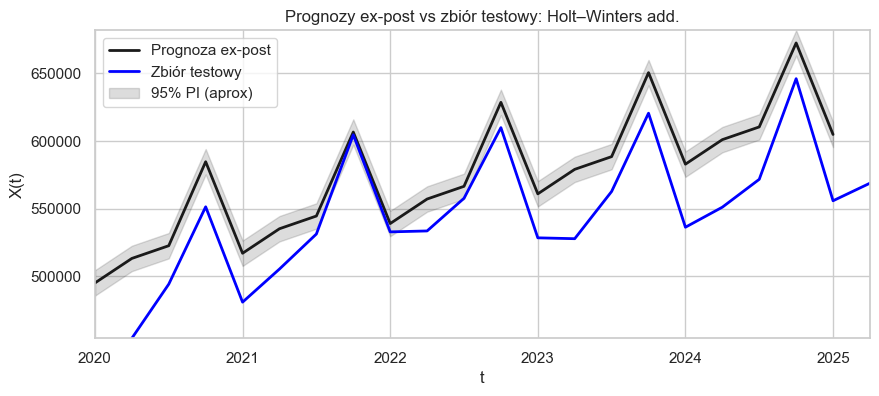

In [7]:
# 3) Holt–Winters addytywny: prognozowanie ex-post (backtest)
# Podział: uczący 2003Q1–2019Q4, test od 2020Q1
train_end = pd.Period('2019Q4', freq='Q')
Xlearn = Xts.loc[:train_end.to_timestamp(how='end')]
Xtest = Xts.loc[train_end.asfreq('Q').asfreq('Q').to_timestamp(how='end') + pd.offsets.QuarterBegin():]
H_expost = len(Xtest)

hw_add2 = ExponentialSmoothing(
    Xlearn,
    trend='add',
    seasonal='add',
    seasonal_periods=4,
    initialization_method='estimated'
).fit(optimized=True)

fc_expost = hw_add2.forecast(H_expost)
resid_std2 = np.nanstd(hw_add2.resid, ddof=1)
lo95_expost = fc_expost - z * resid_std2
hi95_expost = fc_expost + z * resid_std2

# Kryteria jakości (ex-post)
rmse = float(np.sqrt(np.mean((Xtest.values - fc_expost.values)**2)))
mae  = float(np.mean(np.abs(Xtest.values - fc_expost.values)))
mape = float(np.mean(np.abs((Xtest.values - fc_expost.values)/Xtest.values)) * 100)
print('RMSE, MAE, MAPE[%]:', rmse, mae, mape)

# Wykres: test vs prognoza
y_ = float(min(lo95_expost.min(), Xtest.min()))
Y_ = float(max(hi95_expost.max(), Xtest.max()))
fig, ax = plt.subplots()
fc_expost.plot(ax=ax, color='k', lw=2, label='Prognoza ex-post')
Xtest.plot(ax=ax, color='blue', lw=2, label='Zbiór testowy')
ax.fill_between(fc_expost.index, lo95_expost, hi95_expost, color='k', alpha=0.15, label='95% PI (aprox)')
ax.set_ylim(y_, Y_)
ax.set_title('Prognozy ex-post vs zbiór testowy: Holt–Winters add.')
ax.set_xlabel('t')
ax.set_ylabel('X(t)')
ax.legend(loc='best')
ax.grid(True)
plt.show()

RMSE, MAE, MAPE[%]: 61426.14763042808 45992.623997508104 8.463641064362301


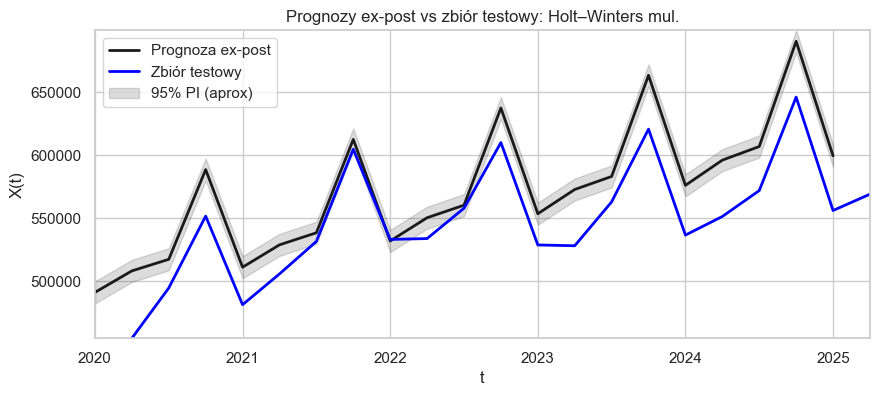

In [18]:
# 3) Holt–Winters multiplikatywny: prognozowanie ex-post (backtest)
# Podział: uczący 2003Q1–2019Q4, test od 2020Q1
train_end = pd.Period('2019Q4', freq='Q')
Xlearn = Xts.loc[:train_end.to_timestamp(how='end')]
Xtest = Xts.loc[train_end.asfreq('Q').asfreq('Q').to_timestamp(how='end') + pd.offsets.QuarterBegin():]
H_expost = len(Xtest)

hw_mul2 = ExponentialSmoothing(
    Xlearn,
    trend='mul',
    seasonal='mul',
    seasonal_periods=4,
    initialization_method='estimated'
).fit(optimized=True)

fc_expost = hw_mul2.forecast(H_expost)
resid_std2 = np.nanstd(hw_mul2.resid, ddof=1)
lo95_expost = fc_expost - z * resid_std2
hi95_expost = fc_expost + z * resid_std2

# Kryteria jakości (ex-post)
rmse = float(np.sqrt(np.mean((Xtest.values - fc_expost.values)**2)))
mae  = float(np.mean(np.abs(Xtest.values - fc_expost.values)))
mape = float(np.mean(np.abs((Xtest.values - fc_expost.values)/Xtest.values)) * 100)
print('RMSE, MAE, MAPE[%]:', rmse, mae, mape)

# Wykres: test vs prognoza
y_ = float(min(lo95_expost.min(), Xtest.min()))
Y_ = float(max(hi95_expost.max(), Xtest.max()))
fig, ax = plt.subplots()
fc_expost.plot(ax=ax, color='k', lw=2, label='Prognoza ex-post')
Xtest.plot(ax=ax, color='blue', lw=2, label='Zbiór testowy')
ax.fill_between(fc_expost.index, lo95_expost, hi95_expost, color='k', alpha=0.15, label='95% PI (aprox)')
ax.set_ylim(y_, Y_)
ax.set_title('Prognozy ex-post vs zbiór testowy: Holt–Winters mul.')
ax.set_xlabel('t')
ax.set_ylabel('X(t)')
ax.legend(loc='best')
ax.grid(True)
plt.show()

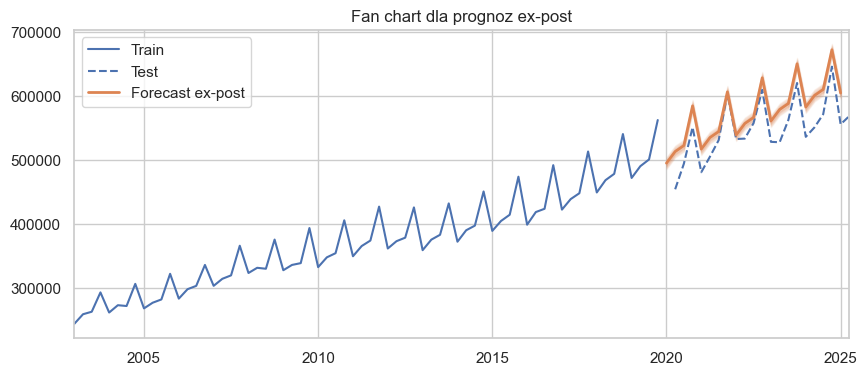

In [8]:
# 4) "forecast.ts" (z R) – tutaj: wykres "fan chart" na bazie kilku poziomów przedziałów
# Zrobimy wielopoziomowe pasma wokół prognozy ex-post
fan_levels = [50, 60, 70, 80, 90, 95]
fig, ax = plt.subplots()
Xlearn.plot(ax=ax, color='C0', lw=1.5, label='Train')
Xtest.plot(ax=ax, color='C0', lw=1.5, linestyle='--', label='Test')
fc_expost.plot(ax=ax, color='C1', lw=2, label='Forecast ex-post')
for lvl in fan_levels:
    z_lvl = stats.norm.ppf(0.5 + lvl/200.0)
    band_low = fc_expost - z_lvl * resid_std2
    band_high = fc_expost + z_lvl * resid_std2
    ax.fill_between(fc_expost.index, band_low, band_high, alpha=0.08, color='C1')
ax.set_title('Fan chart dla prognoz ex-post')
ax.legend(loc='best')
ax.grid(True)
plt.show()

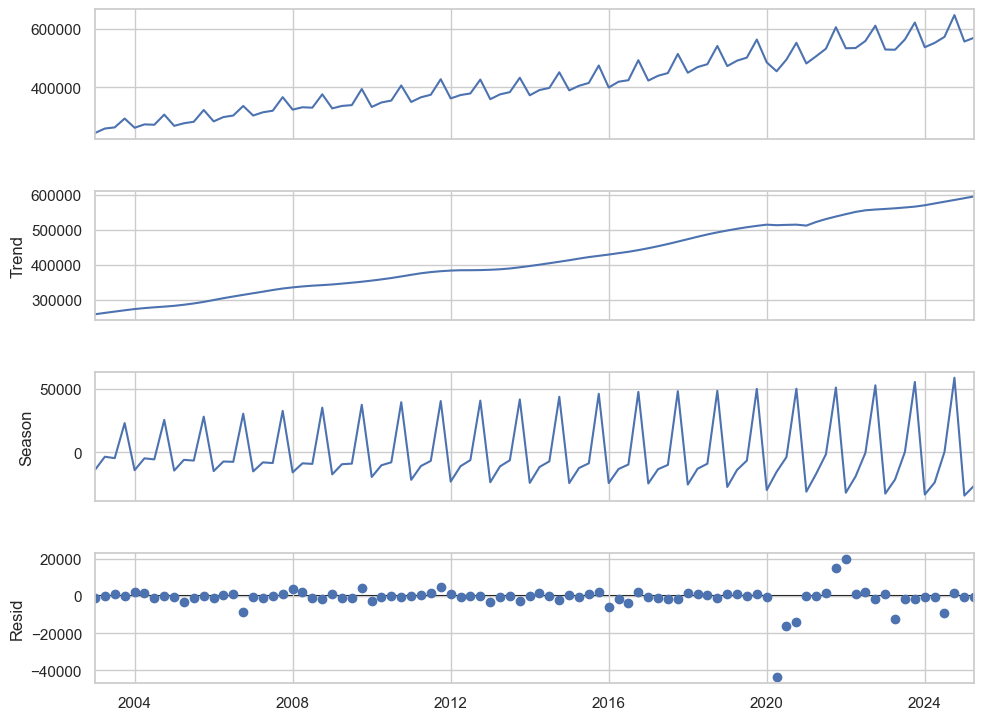

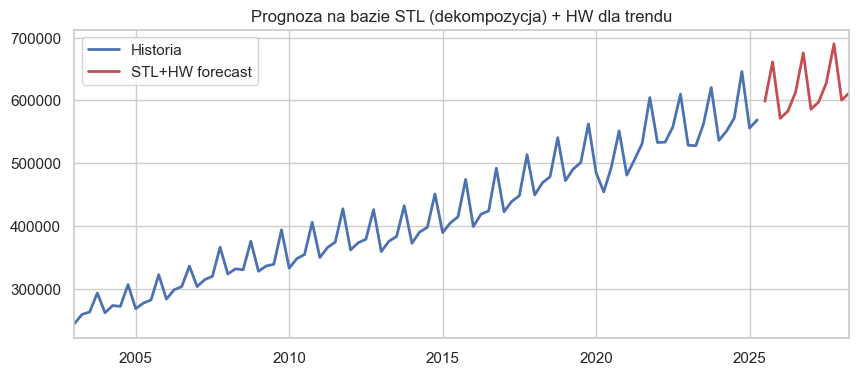

In [9]:
# 5) Dekompozycja STL i prognozowanie
# Dekompozycja na trend, sezonowość, resztę
stl = STL(Xts, period=4, robust=True)
stl_res = stl.fit()
fig = stl_res.plot()
fig.set_size_inches(10, 8)
plt.show()

# Prosty sposób prognozowania: model HW na serii odsezonowanej, potem dodanie sezonowości
seasonal = stl_res.seasonal
trend = stl_res.trend
adj = Xts - seasonal  # odsezonowane

hw_adj = ExponentialSmoothing(adj, trend='add', seasonal=None, initialization_method='estimated').fit()
fc_adj = hw_adj.forecast(12)
# dołóż sezonowość okresu 4: weź ostatnie 4 sezony i cyklicznie powiel
last_season = seasonal[-4:]
seasonal_fc = pd.Series(np.resize(last_season.values, 12), index=fc_adj.index)
fc_stl = fc_adj + seasonal_fc

fig, ax = plt.subplots()
Xts.plot(ax=ax, color='C0', lw=2, label='Historia')
fc_stl.plot(ax=ax, color='C3', lw=2, label='STL+HW forecast')
ax.set_title('Prognoza na bazie STL (dekompozycja) + HW dla trendu')
ax.grid(True)
ax.legend(loc='best')
plt.show()

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                   90
Model:                       ETS(AAA)   Log Likelihood                -972.651
Date:                Wed, 29 Oct 2025   AIC                           1965.303
Time:                        10:18:46   BIC                           1990.301
Sample:                    01-01-2003   HQIC                          1975.383
                         - 04-01-2025   Scale                    142748758.661
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.3996        nan        nan        nan         nan         nan
smoothing_trend        0.0053        nan        nan        nan         nan         nan
smoothing_seasonal  

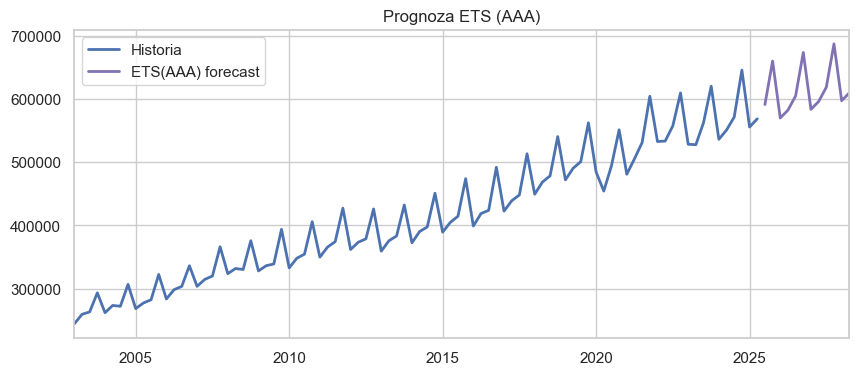

In [10]:
# 6) ETS – pełna rodzina wygładzeń wykładniczych: przykładowy model AAA
ets = ETSModel(Xts, error='add', trend='add', seasonal='add', seasonal_periods=4)
ets_fit = ets.fit()
print(ets_fit.summary())

ets_fc = ets_fit.forecast(12)
fig, ax = plt.subplots()
Xts.plot(ax=ax, color='C0', lw=2, label='Historia')
ets_fc.plot(ax=ax, color='C4', lw=2, label='ETS(AAA) forecast')
ax.set_title('Prognoza ETS (AAA)')
ax.grid(True)
ax.legend(loc='best')
plt.show()